In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

!pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler


In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [9]:
!ls /content/drive/MyDrive/


 1906032		     passport_photo_1.jpg
'1906032_Santrupti Golhar'   Resume_Santrupti.pdf
 aadhar_card.jpg	    'SantruptiGolhar_TYAIMLA70_2025Batch (1).pdf'
 application_train.csv	     SantruptiGolhar_TYAIMLA70_2025Batch.pdf
 Classroom		     Santrupti_Resume_final_draft.pdf
'Colab Notebooks'	     Santrupti_Resume_syngenta.pdf
 COWIN_Certificate.pdf	     signature.pdf
'Getting started.pdf'	     titanic.csv
'Java Project Files'	     virtual_id.jpg
'my pic.jpg'


In [19]:
# Load Titanic dataset
def load_titanic():
    data = pd.read_csv("/content/drive/MyDrive/titanic.csv")
    return data

# Load application_train dataset
def load_application_train():
    data = pd.read_csv("/content/drive/MyDrive/application_train.csv")
    return data

# See the shape of the datasets
titanic_df = load_titanic()
app_train_df = load_application_train()

print(titanic_df.shape)       # (891, 12)
print(app_train_df.shape)     # (307511, 122)



(891, 12)
(307511, 122)


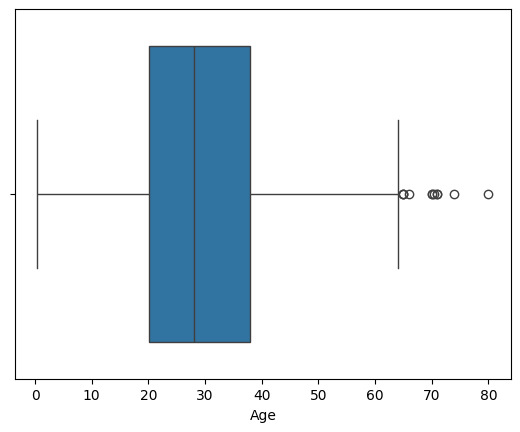

In [11]:
#detect outliers in a numerical 'Age' column by using boxplot.

sns.boxplot(x=df["Age"])
plt.show()

In [20]:
# Function to detect outliers using IQR
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


In [21]:
# Function to check if there are outliers in a column
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [22]:
# Function to grab column names
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" and col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car

In [23]:
# Handling missing values
def handle_missing_values(dataframe):
    dataframe = dataframe.copy()
    # Fill missing values for numerical columns with the median
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != 'O']
    for col in num_cols:
        dataframe[col].fillna(dataframe[col].median(), inplace=True)
    # Fill missing values for categorical columns with the mode
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']
    for col in cat_cols:
        dataframe[col].fillna(dataframe[col].mode()[0], inplace=True)
    return dataframe

In [27]:
#function that check if there are any outliers.
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

print(check_outlier(df, "Age"))
print(check_outlier(df, "Fare"))

True
True


In [25]:
# Encoding categorical variables
def encode_categorical(dataframe):
    dataframe = dataframe.copy()
    cat_cols, _, _ = grab_col_names(dataframe)
    for col in cat_cols:
        if dataframe[col].nunique() <= 2:
            le = LabelEncoder()
            dataframe[col] = le.fit_transform(dataframe[col])
        else:
            dataframe = pd.get_dummies(dataframe, columns=[col], drop_first=True)
    return dataframe

In [24]:
# Scaling numerical features
def scale_numerical(dataframe):
    dataframe = dataframe.copy()
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != 'O']
    scaler = StandardScaler()
    dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])
    return dataframe


In [28]:
# Feature generation: Creating new features
def generate_features(dataframe):
    dataframe = dataframe.copy()
    # Example: Creating a family size feature in Titanic dataset
    if 'SibSp' in dataframe.columns and 'Parch' in dataframe.columns:
        dataframe['FamilySize'] = dataframe['SibSp'] + dataframe['Parch'] + 1
    return dataframe

In [41]:
# Plot distribution of numerical features
def plot_num_feature_distribution(dataframe, cols, n_cols=2):
    n_rows = (len(cols) + n_cols - 1) // n_cols  # Calculate the number of rows needed
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Flatten axes array to easily iterate over it
    for i, col in enumerate(cols):
        sns.histplot(dataframe[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    # Remove any empty subplots
    for i in range(len(cols), len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

In [42]:
# Plot distribution of categorical features
def plot_cat_feature_distribution(dataframe, cols, n_cols=2):
    n_rows = (len(cols) + n_cols - 1) // n_cols  # Calculate the number of rows needed
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Flatten axes array to easily iterate over it
    for i, col in enumerate(cols):
        sns.countplot(data=dataframe, x=col, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
    # Remove any empty subplots
    for i in range(len(cols), len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()


In [43]:
# Visualize the correlation matrix
def plot_correlation_matrix(dataframe):
    numeric_df = dataframe.select_dtypes(include=[np.number])
    corr = numeric_df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

Processing Titanic dataset:
Observations: 891
Variables: 24
cat_cols: 18
num_cols: 3
cat_but_car: 3
num_but_cat: 18


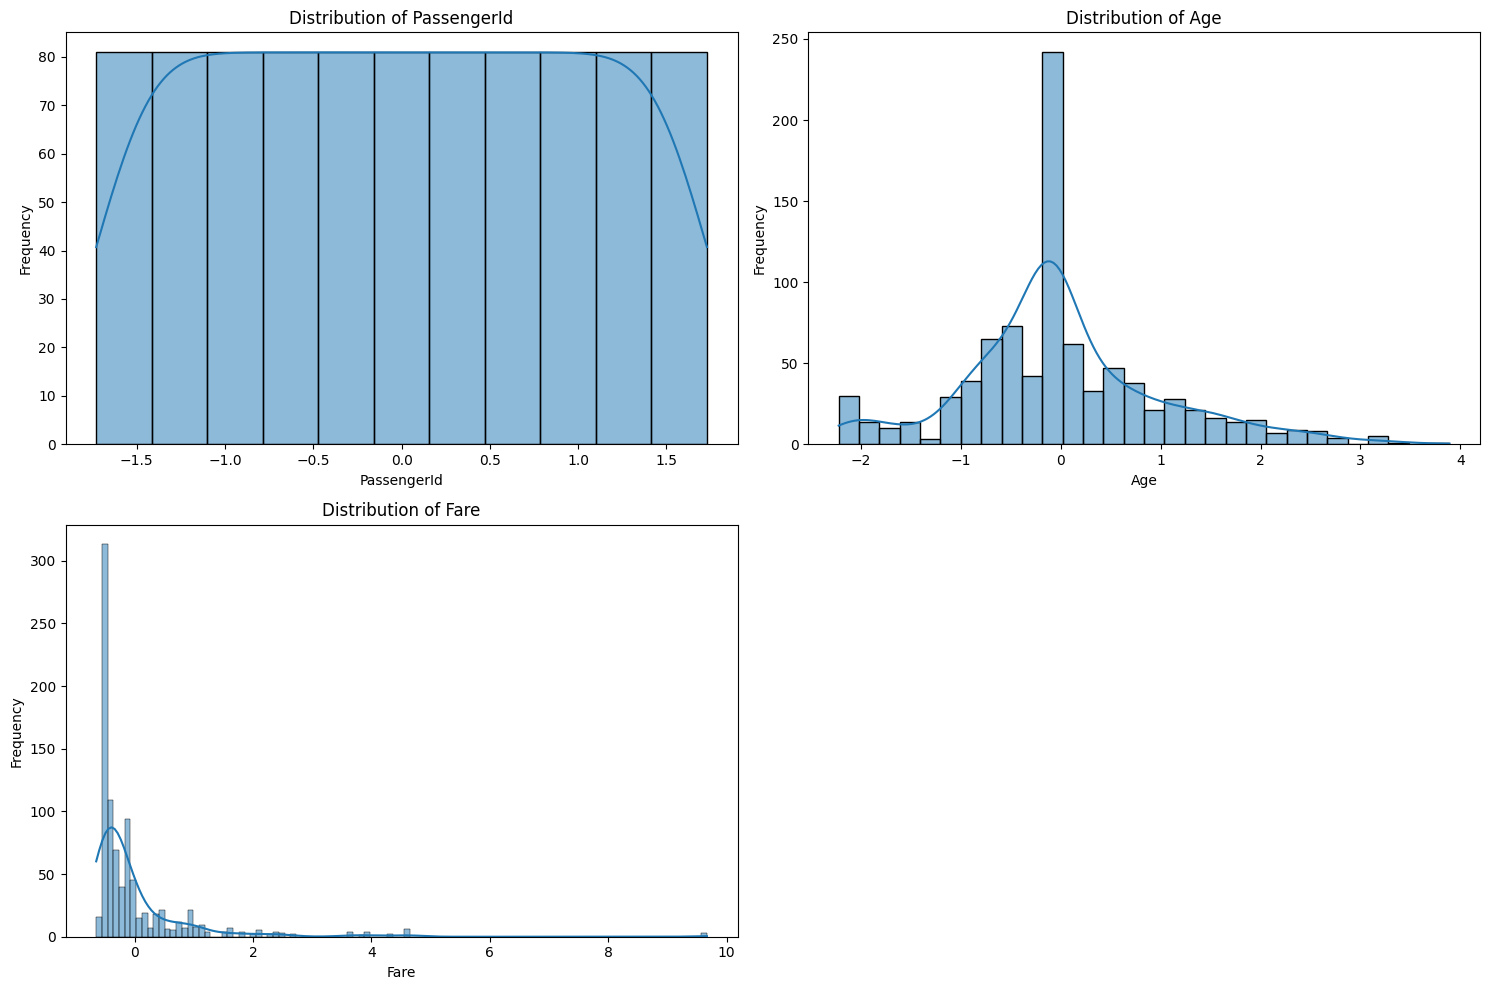

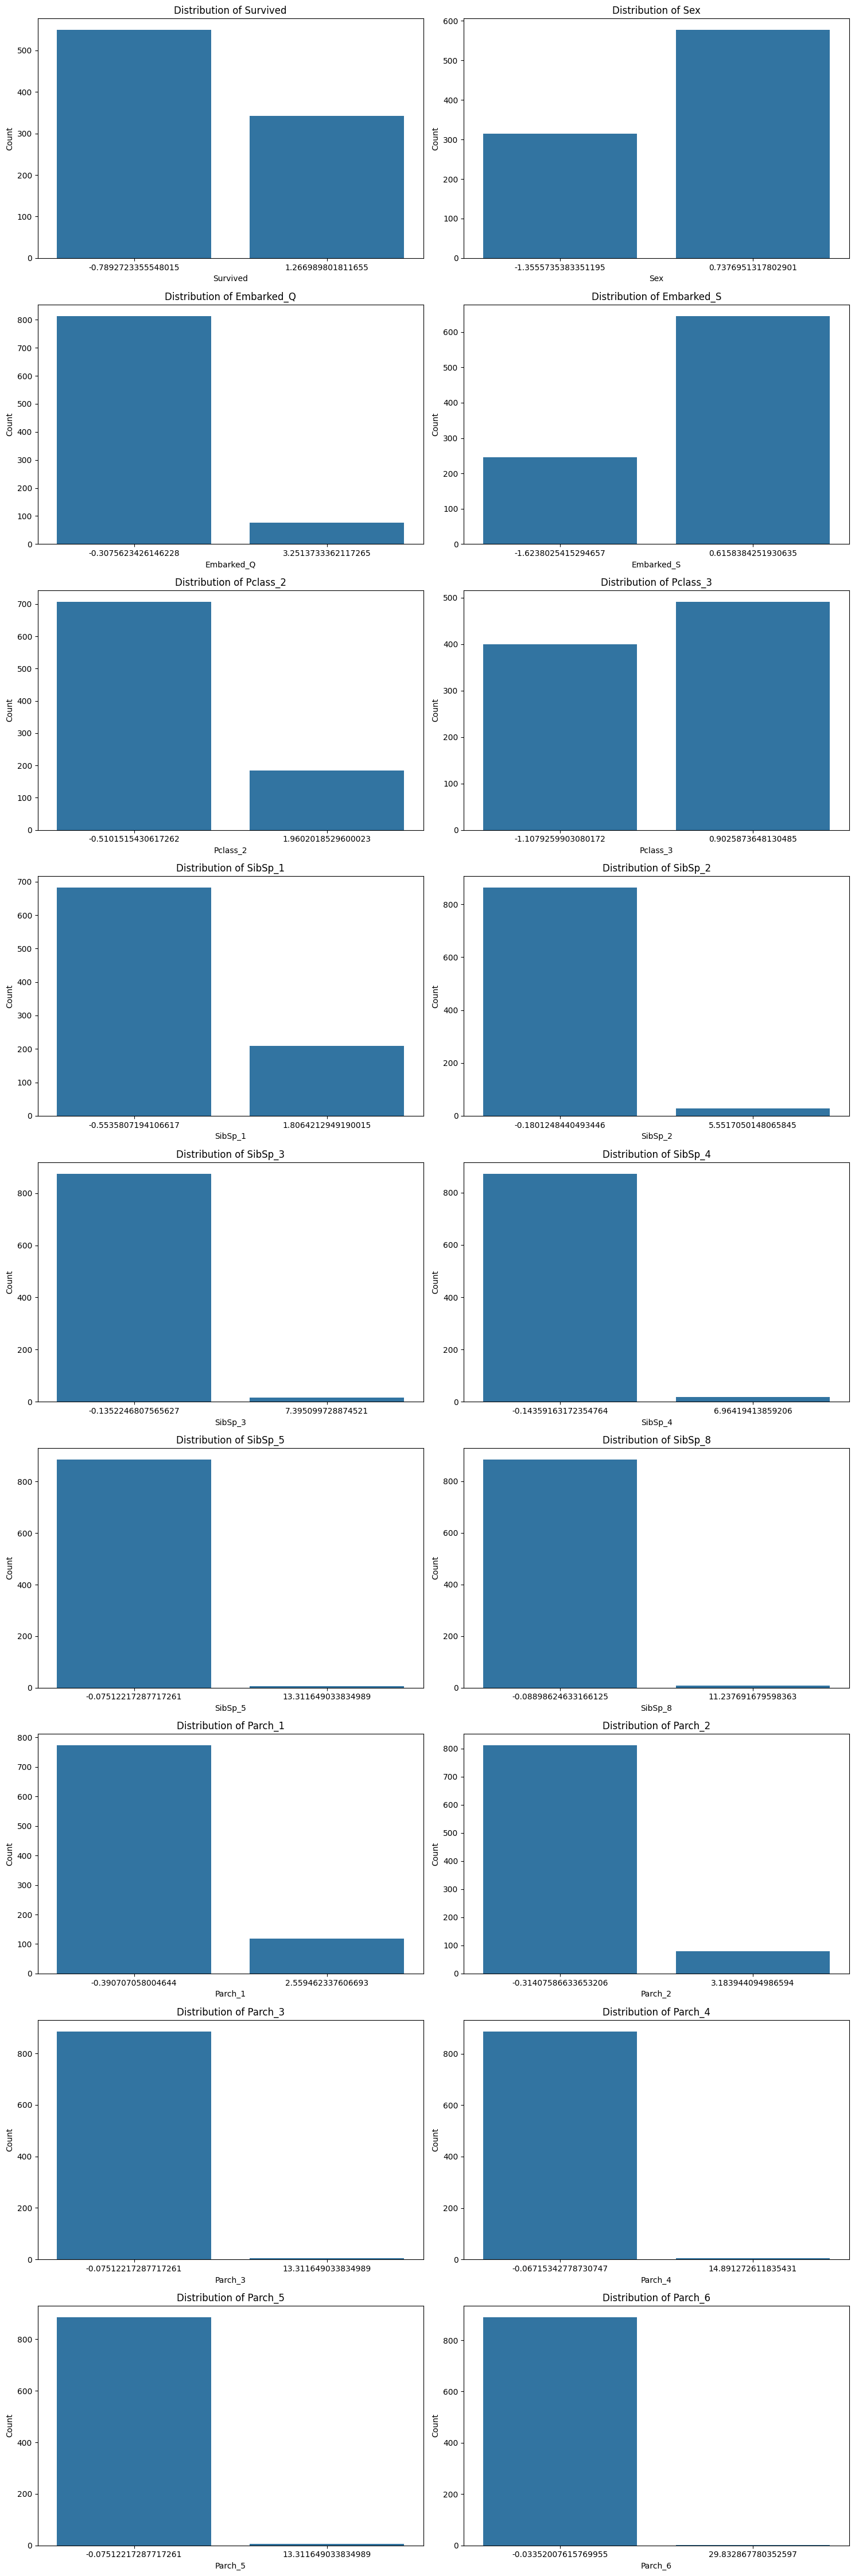

Observations: 891
Variables: 24
cat_cols: 18
num_cols: 3
cat_but_car: 3
num_but_cat: 18


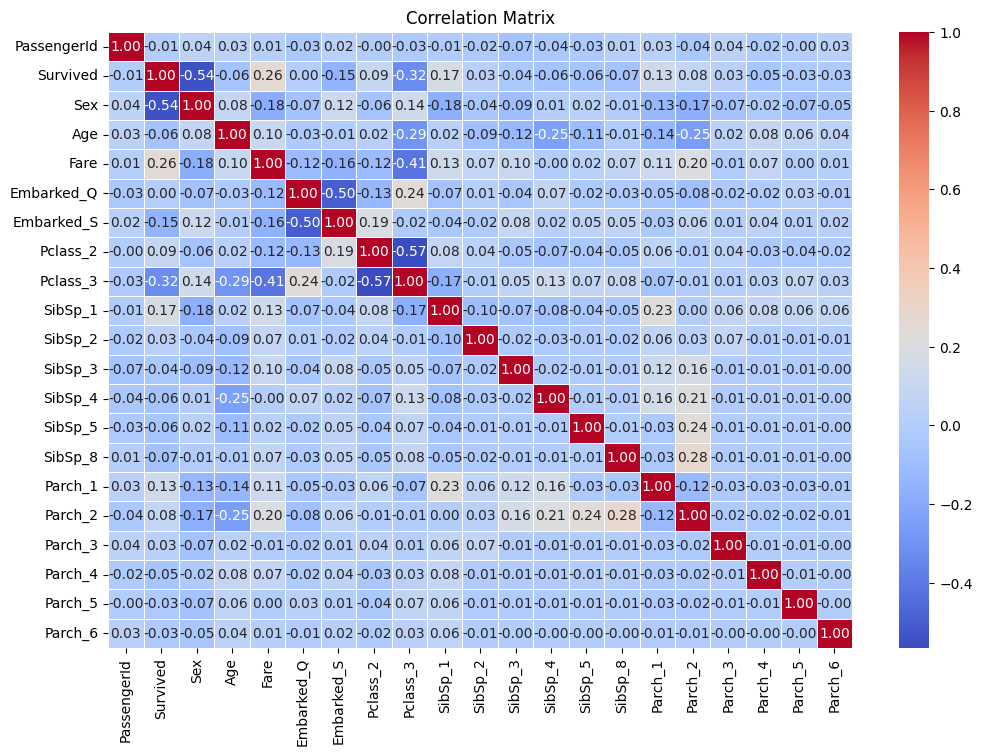

   PassengerId  Survived                                               Name  \
0    -1.730108 -0.789272                            Braund, Mr. Owen Harris   
1    -1.726220  1.266990  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2    -1.722332  1.266990                             Heikkinen, Miss. Laina   
3    -1.718444  1.266990       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4    -1.714556 -0.789272                           Allen, Mr. William Henry   

        Sex       Age            Ticket      Fare    Cabin  Embarked_Q  \
0  0.737695 -0.565736         A/5 21171 -0.502445  B96 B98   -0.307562   
1 -1.355574  0.663861          PC 17599  0.786845      C85   -0.307562   
2 -1.355574 -0.258337  STON/O2. 3101282 -0.488854  B96 B98   -0.307562   
3 -1.355574  0.433312            113803  0.420730     C123   -0.307562   
4  0.737695  0.433312            373450 -0.486337  B96 B98   -0.307562   

   Embarked_S  ...   SibSp_3   SibSp_4   SibSp_5   SibSp_8   Parch_1  \
0    0.6

In [46]:
# Process and visualize Titanic dataset
print("Processing Titanic dataset:")
titanic_df = handle_missing_values(titanic_df)
cat_cols, num_cols, _ = grab_col_names(titanic_df)
plot_num_feature_distribution(titanic_df, num_cols)
plot_cat_feature_distribution(titanic_df, cat_cols)
titanic_df = encode_categorical(titanic_df)
plot_correlation_matrix(titanic_df)
titanic_df = generate_features(titanic_df)
titanic_df = scale_numerical(titanic_df)
print(titanic_df.head())

Processing application_train dataset:
Observations: 307511
Variables: 200
cat_cols: 132
num_cols: 67
cat_but_car: 1
num_but_cat: 132


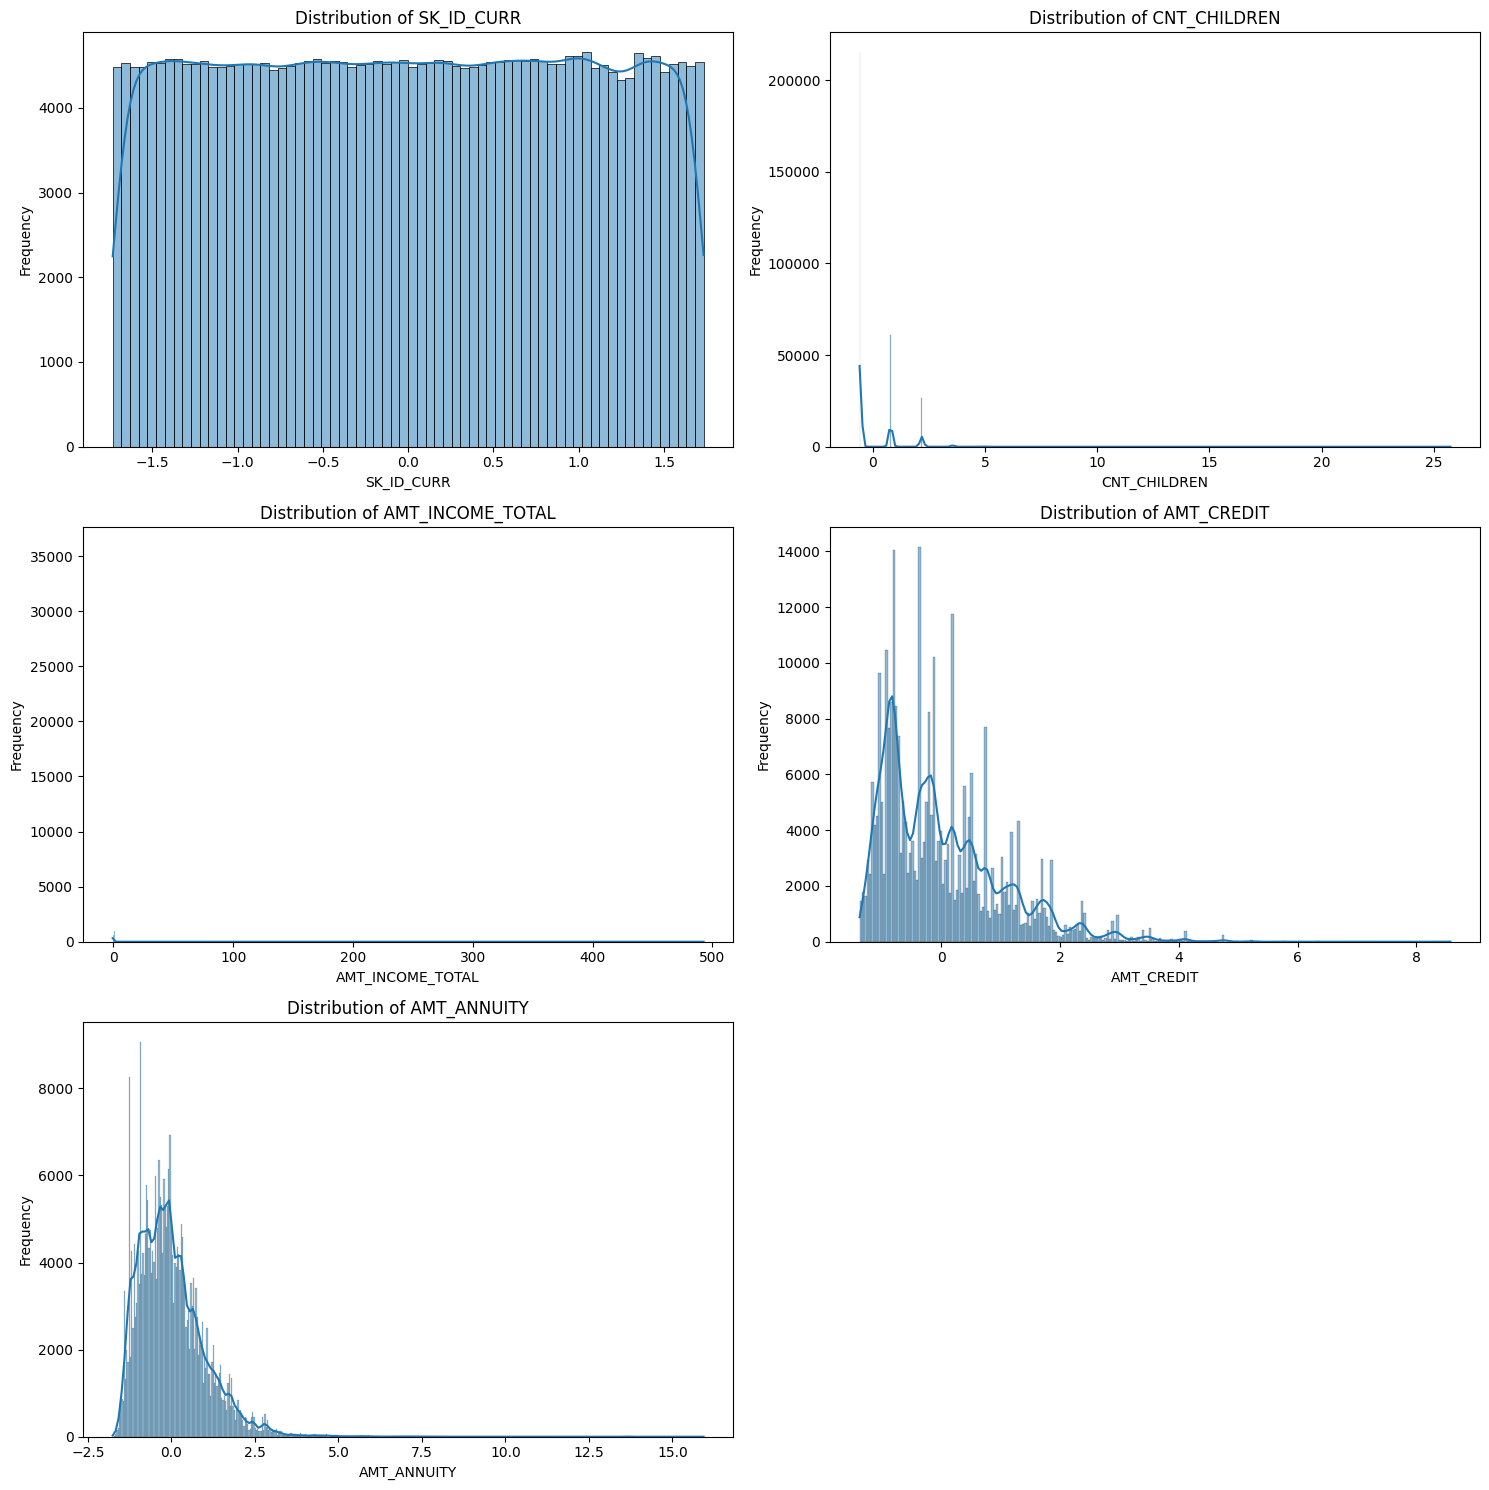

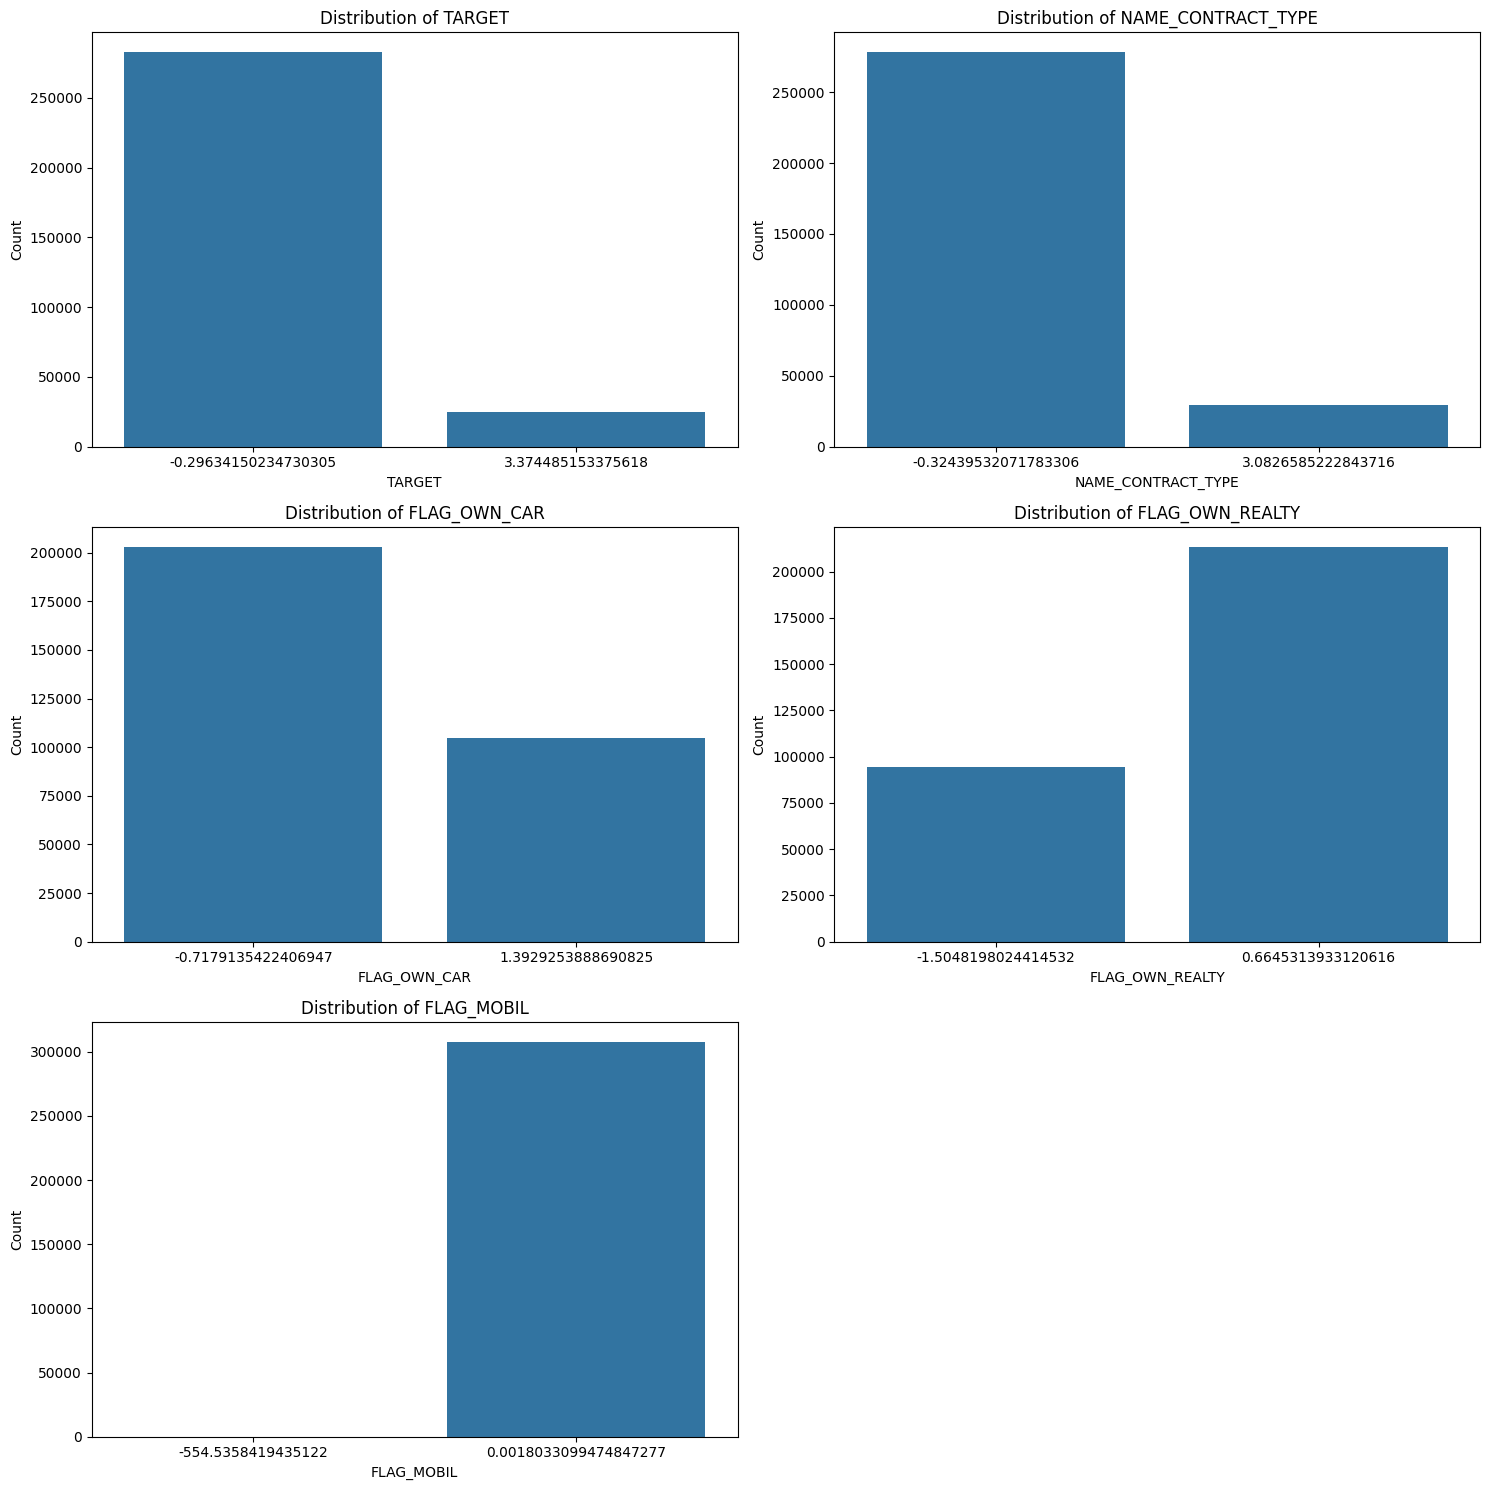

Observations: 307511
Variables: 200
cat_cols: 132
num_cols: 67
cat_but_car: 1
num_but_cat: 132


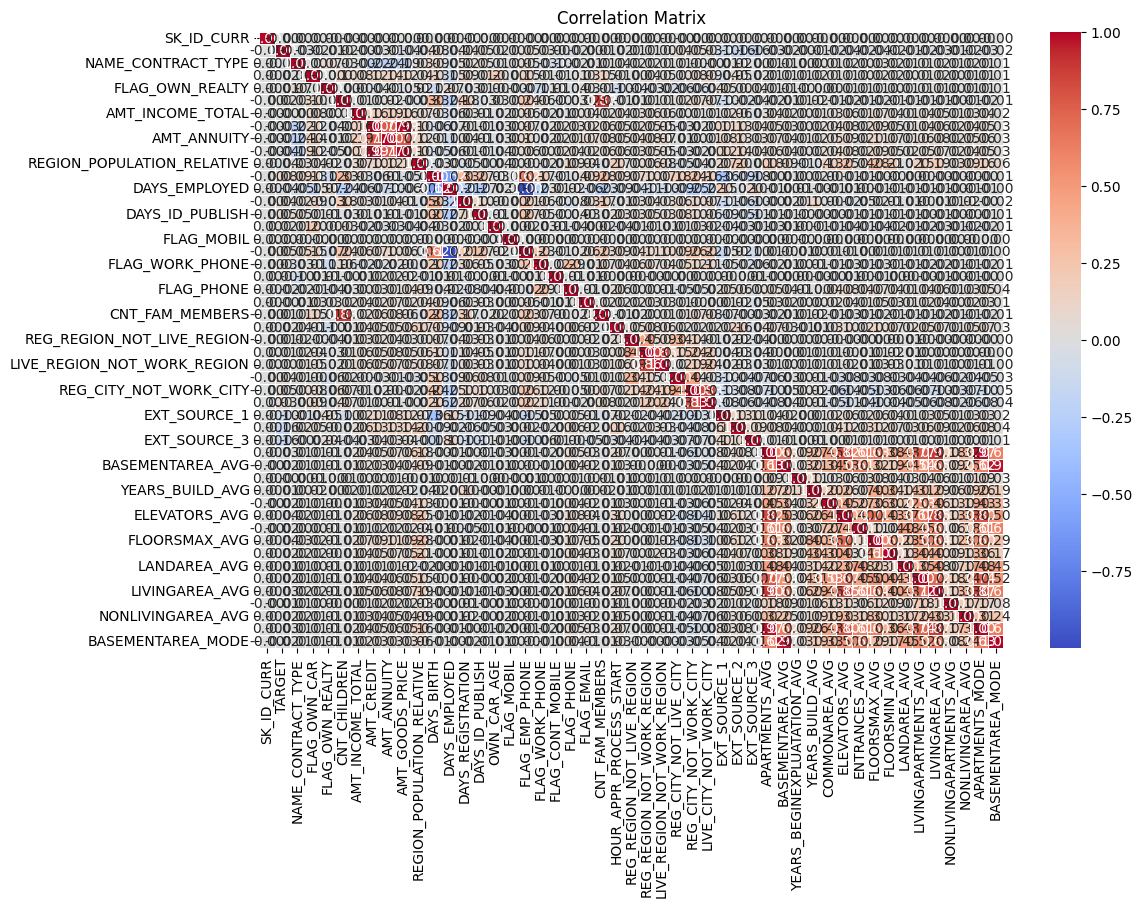

   SK_ID_CURR    TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0   -1.733423  3.374485           -0.324395     -0.717914         0.664531   
1   -1.733413 -0.296342           -0.324395     -0.717914        -1.504820   
2   -1.733403 -0.296342            3.082659      1.392925         0.664531   
3   -1.733384 -0.296342           -0.324395     -0.717914         0.664531   
4   -1.733374 -0.296342           -0.324395     -0.717914         0.664531   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0     -0.577538          0.142129   -0.478095    -0.166143        -0.507236   
1     -0.577538          0.426792    1.725450     0.592683         1.600873   
2     -0.577538         -0.427196   -1.152888    -1.404669        -1.092145   
3     -0.577538         -0.142533   -0.711430     0.177874        -0.653463   
4     -0.577538         -0.199466   -0.213734    -0.361749        -0.068554   

   ...  AMT_REQ_CREDIT_BUREAU_DAY_8.0  AMT_REQ_CREDIT_BU

In [45]:
# Process and visualize application_train dataset
print("Processing application_train dataset:")
app_train_df = handle_missing_values(app_train_df)
cat_cols, num_cols, _ = grab_col_names(app_train_df)
plot_num_feature_distribution(app_train_df, num_cols[:5])  # Plotting only first 5 numerical features for brevity
plot_cat_feature_distribution(app_train_df, cat_cols[:5])  # Plotting only first 5 categorical features for brevity
app_train_df = encode_categorical(app_train_df)
plot_correlation_matrix(app_train_df.iloc[:, :50])  # Plotting only first 50 features for readability
app_train_df = generate_features(app_train_df)
app_train_df = scale_numerical(app_train_df)
print(app_train_df.head())